# Lesson 1: Image classifier model
A notebook based on Lesson 1 of the Fast AI course.

It has often been said (by me) that the Volkswagen Golf is the Rolls Royce of automobiles.

In this notebook, we will train a model to attempt the lofty task of distinguishing Volkswagen Golfs from Rolls Royces.

## 0. Setup
Imports and constants.

In [1]:
from pathlib import Path
from time import sleep

from duckduckgo_search import ddg_images
from fastai.vision.all import (
    Image, download_images, resize_images,
    verify_images, get_image_files,
    vision_learner, ImageBlock, CategoryBlock, Resize,
    resnet18, error_rate
)
from fastai.vision.core import DataBlock, RandomSplitter, parent_label, PILImage
from fastdownload import download_url

/home/gurp/miniconda3/envs/ml-practice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMAGE_FPATH = Path().absolute().parents[1] / 'datasets' / 'fastai' / 'lesson1'
NUM_IMAGES_PER_CLASS = 100
MAX_IMAGE_SIZE = 400

## 1. Download a set of training data images
We will use duckduckgo to search for images of positive (VW Golf) and negative (Rolls Royce) examples of images.

In [3]:
def get_image_urls(term, max_results=30):
    """list of str: Return image urls for the given search term."""
    search_res = ddg_images(term, max_results=max_results)
    image_urls = [k['image'] for k in search_res]
    return image_urls

In [14]:
search_terms = ('volkswagen golf', 'rolls royce')

for search_term in search_terms:
    destination_path = IMAGE_FPATH / search_term.replace(' ', '_')
    destination_path.mkdir(parents=True, exist_ok=True)
    image_urls = get_image_urls(search_term, max_results=NUM_IMAGES_PER_CLASS)
    download_images(destination_path, urls=image_urls, max_pics=NUM_IMAGES_PER_CLASS)
    resize_images(path=destination_path, max_size=MAX_IMAGE_SIZE, dest=destination_path)
    sleep(10)  # Pause between searches to avoid over-loading server

/home/gurp/miniconda3/envs/ml-practice/lib/python3.11/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/home/gurp/miniconda3/envs/ml-practice/lib/python3.11/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/home/gurp/miniconda3/envs/ml-practice/lib/python3.11/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


Load an image example

In [15]:
destination_path.ls()[0]

Path('/home/gurp/workspace/ml-practice/ml-practice/datasets/fastai/lesson1/rolls_royce/19057053-a9d1-48e5-9619-428ebe8459ca.jpg')

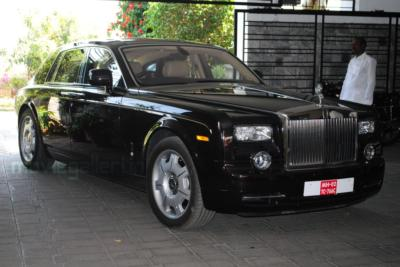

In [16]:
Image.open(destination_path.ls()[0])

## 2. Train the model
Train a CNN on the data.

### 2.1 Remove any images bad images from the dataset
Some files may not have downloaded correctly.

In [10]:
failed = verify_images(get_image_files(IMAGE_FPATH))
failed

(#5) [Path('/home/gurp/workspace/ml-practice/ml-practice/datasets/fastai/lesson1/volkswagen_golf/2105507a-6bc5-4bb8-ba53-599b6bcc8cb0.png'),Path('/home/gurp/workspace/ml-practice/ml-practice/datasets/fastai/lesson1/volkswagen_golf/2ee7b243-3d86-4881-8c35-43634031cf76.jpg'),Path('/home/gurp/workspace/ml-practice/ml-practice/datasets/fastai/lesson1/rolls_royce/cebd4571-94b8-4ede-8b71-bd940d6af9c0.jpg'),Path('/home/gurp/workspace/ml-practice/ml-practice/datasets/fastai/lesson1/rolls_royce/5dd3ee37-8c3b-46aa-8564-ff50ac2d67d6.jpg'),Path('/home/gurp/workspace/ml-practice/ml-practice/datasets/fastai/lesson1/rolls_royce/a50b6eee-1bde-432d-a328-86efe3f85a29.jpg')]

In [11]:
len(failed)

5

In [12]:
[Path.unlink(failed_fpath) for failed_fpath in failed]

[None, None, None, None, None]

### 2.2. Create a DataLoader
This contains the data and splits it into training and validation sets.

In [4]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # The input and output types
    get_items=get_image_files,  # Function that returns a list of all inputs
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # How to split the training/validation set
    get_y=parent_label,  # Function that retuns the label of a given image
    item_tfms=[Resize(192, method='squish')],  # Pre-processing transforms to apply to the input images
)

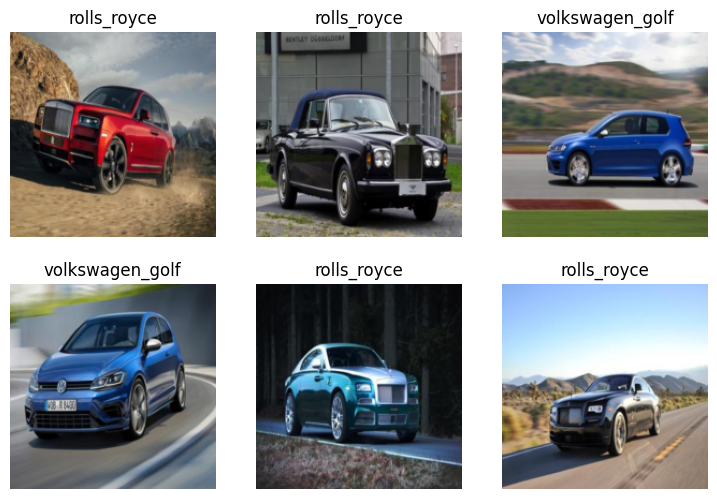

In [5]:
dls = dblock.dataloaders(IMAGE_FPATH, bs=32)
dls.show_batch(max_n=6)

### 2.3. Fine tune a pre-trained model

In [6]:
learner = vision_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(5)

/home/gurp/miniconda3/envs/ml-practice/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gurp/miniconda3/envs/ml-practice/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 2.4. Save model

In [7]:
learner.export('vw_image_model.pkl')

## 3. Make predictions
Use the model on new images to see how well it performs.

In [14]:
test_destination_path = IMAGE_FPATH.parent / 'test_images'
test_destination_path.mkdir(parents=True, exist_ok=True)
test_image_urls = get_image_urls('volkswagen golf track', max_results=5)
download_images(test_destination_path, urls=test_image_urls, max_pics=5)

/home/gurp/miniconda3/envs/ml-practice/lib/python3.11/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/home/gurp/miniconda3/envs/ml-practice/lib/python3.11/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/home/gurp/miniconda3/envs/ml-practice/lib/python3.11/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


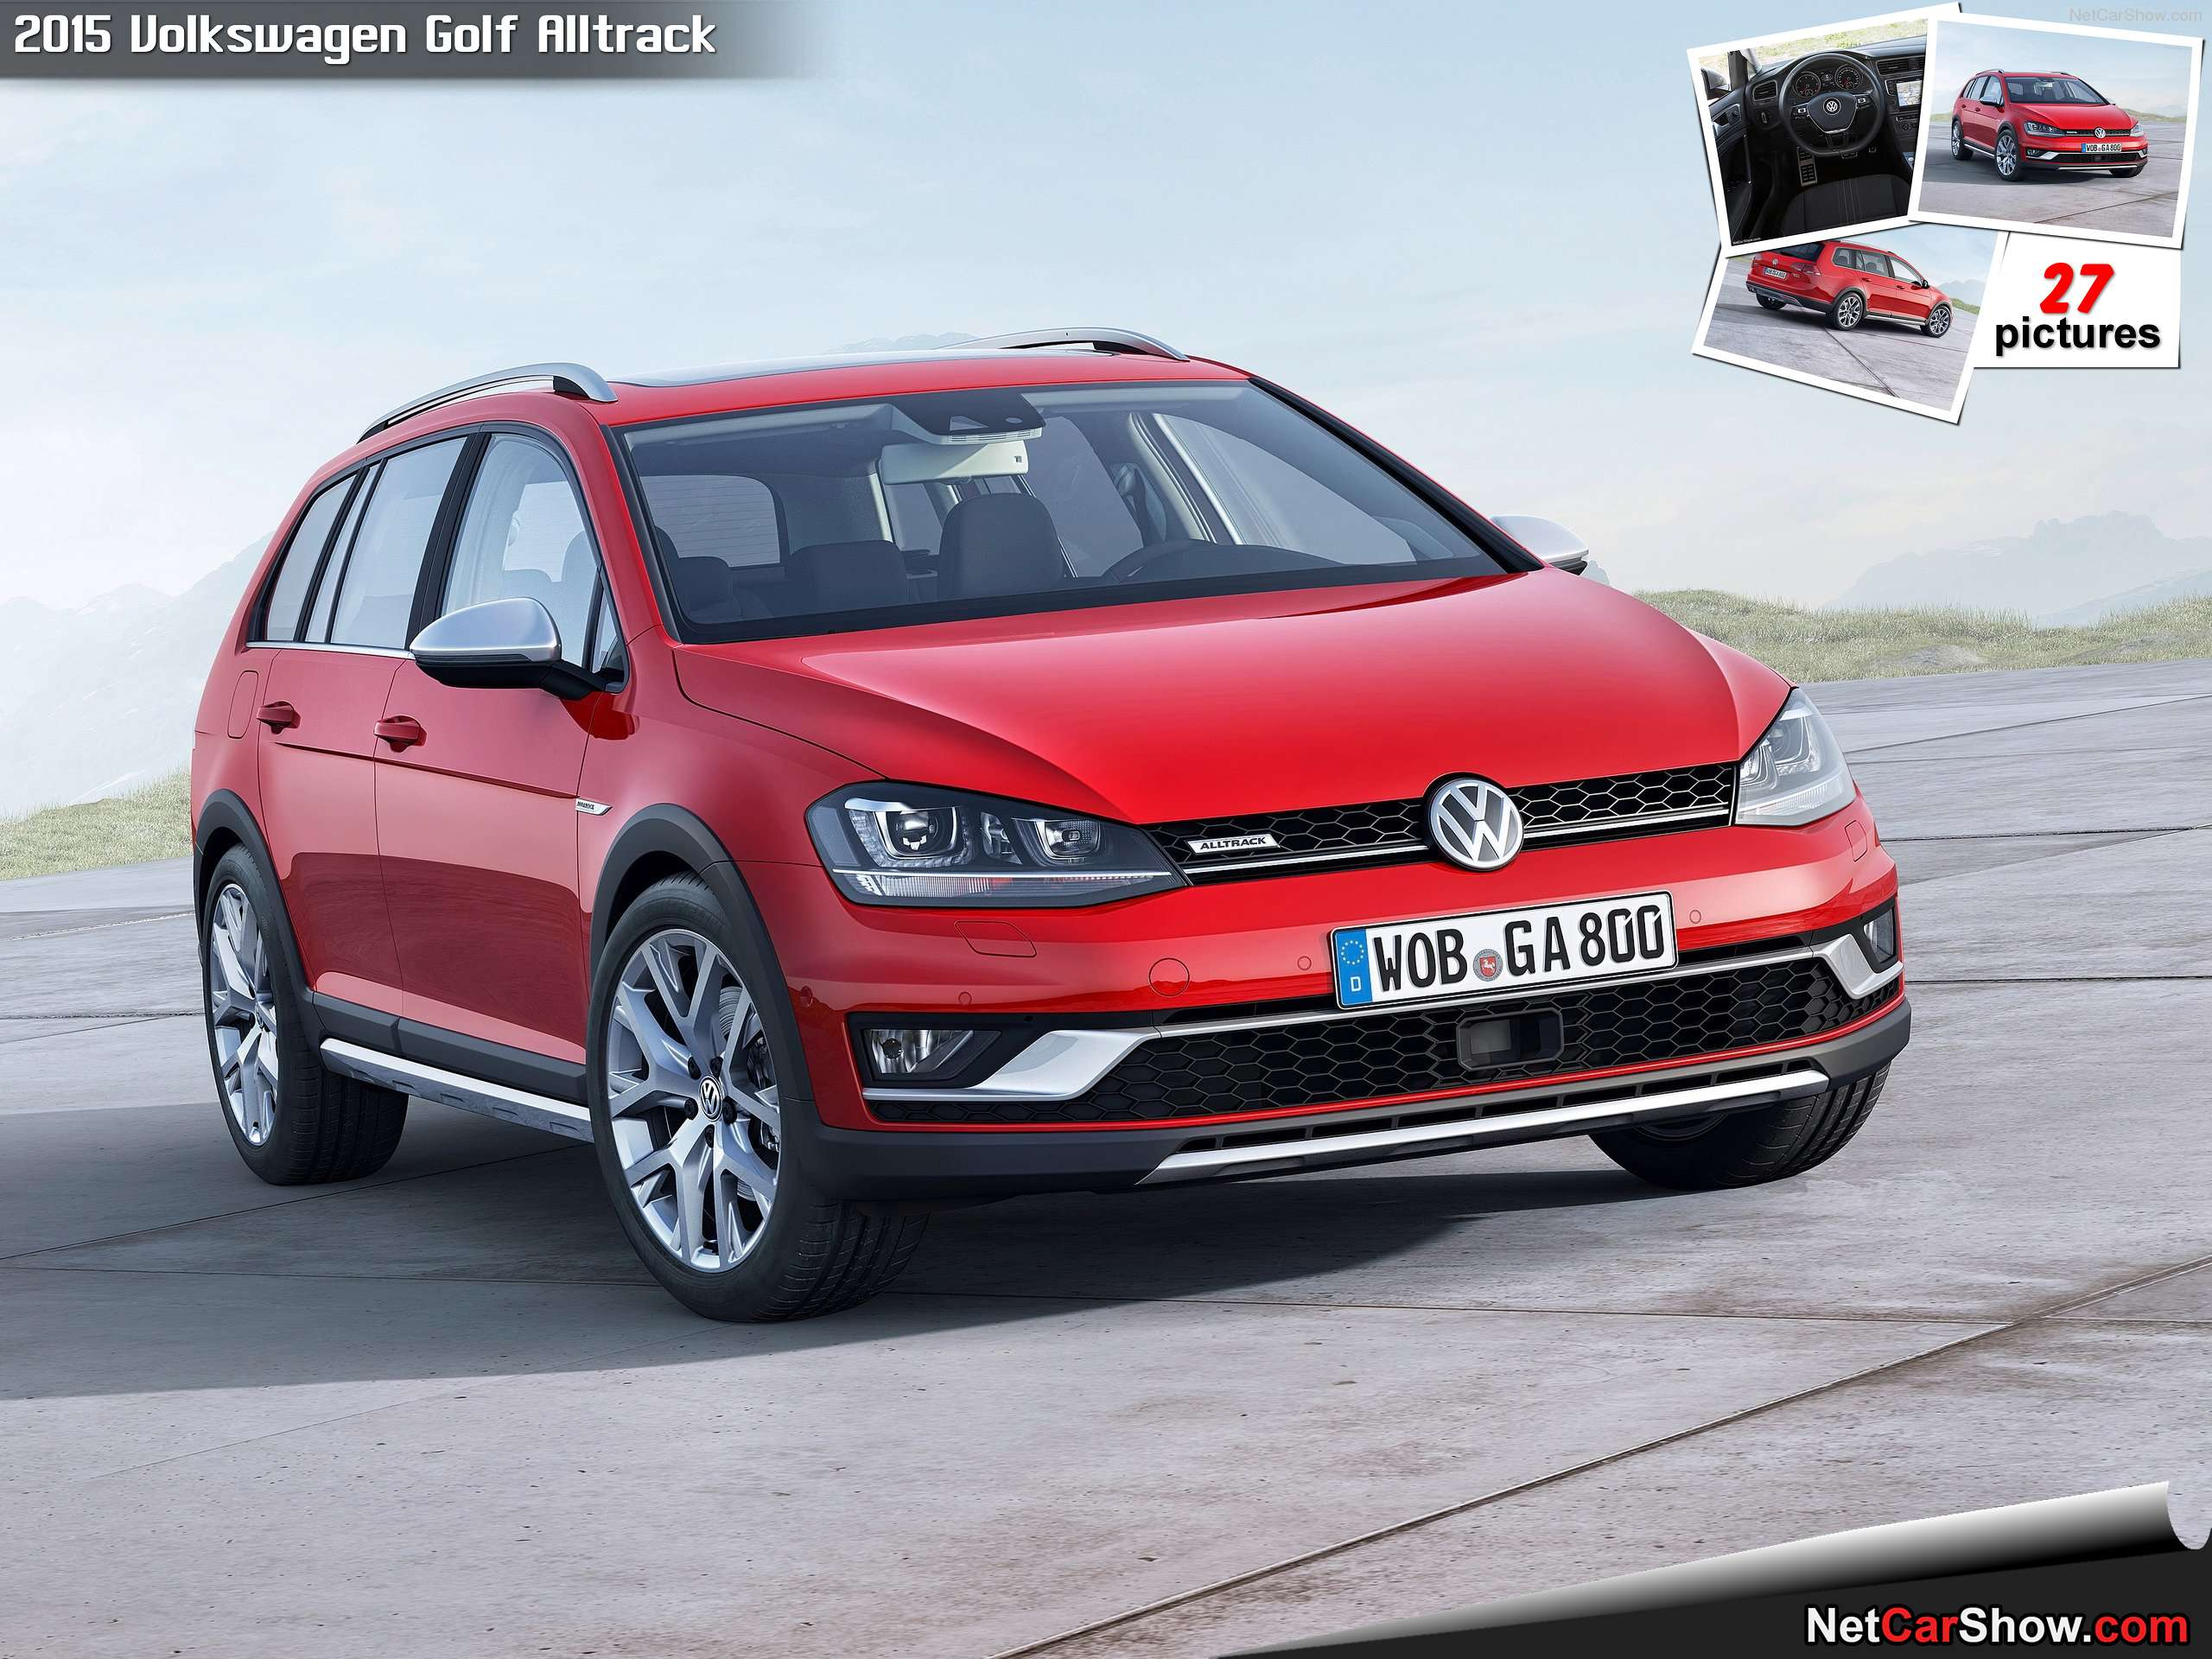

In [16]:
test_destination_path = IMAGE_FPATH.parent / 'test_images'
test_img = PILImage.create(test_destination_path.ls()[1])
test_img

In [17]:
is_golf, idx, probs = learner.predict(test_img)


In [18]:
idx

tensor(1)

In [19]:
is_golf

'volkswagen_golf'

In [20]:
probs

tensor([0.0010, 0.9990])